In [1]:
from __future__ import print_function
import numpy as np
from astropy.io import fits
from marvin.tools import Maps
from tqdm import tqdm

import math as math
import matplotlib.pyplot as plt
import pylab as plb



#from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import scipy as scipy
#from scipy.fft import fft
from scipy import ndimage
from scipy.optimize import curve_fit
import scipy.stats as stats
import math

import copy
import Simpler_Classifier

from importlib import reload 

from hyperopt import hp, fmin, rand, tpe, space_eval
import torch
from torch import nn


from scipy.optimize import leastsq


[INFO]: No release version set. Setting default to DR17
[WARNING]: path /Users/runquanguan/sas/mangawork/manga/spectro/redux/v3_1_1/drpall-v3_1_1.fits cannot be found. Setting drpall to None. (MarvinUserWarning)
[WARNING]: path /Users/runquanguan/sas/mangawork/manga/spectro/analysis/v3_1_1/3.1.0/dapall-v3_1_1-3.1.0.fits cannot be found. Setting dapall to None. (MarvinUserWarning)
[WARNING]: Passing field metadata as keyword arguments is deprecated. Use the explicit `metadata=...` argument instead. Additional metadata: {'location': 'view_args'} (RemovedInMarshmallow4Warning)
[WARNING]: The 'missing' argument to fields is deprecated. Use 'load_default' instead. (RemovedInMarshmallow4Warning)


In [ ]:

my_module = reload(Simpler_Classifier) # reload of Simpler_Classifier without restart

# Gaussian fit method

In [21]:
#data = '9514-1902'
#data = '9187-3702'
#data = ‘8597-1901’ # 156 sample
data = '7968-12702'

In [22]:
origin_curve = np.array(Simpler_Classifier.simple_integ(data))
curve = Simpler_Classifier.normalize(origin_curve)





def cone_norm_model(mu, variance, scale, contin):
    x = np.linspace(0, 36, 36)
    sigma = math.sqrt(variance)
    cone = stats.norm.pdf(x, mu, sigma)*scale
    onecone = cone+contin
    return onecone


def loss_function_c(arg):

    mu, variance, scale, contin= arg
    onecone = cone_norm_model(mu, variance, scale, contin)
    loss = 0
    for i in range(36):
        loss = loss + abs(curve[i]-onecone[i])

    total_loss = loss.item()

    return total_loss

def loss_function_d(arg):

    mu, variance, scale, contin= arg
    onecone = cone_norm_model(mu, variance, scale, contin)
    loss = 0
    for i in range(36):
        loss = loss + abs(curve[i+36]-onecone[i])

    total_loss = loss.item()

    return total_loss

space_norm = [hp.uniform('mu',0, 36), hp.uniform('variance',0, 36), hp.uniform('scale',0, 500), hp.uniform('contin',0, 10)]
best_norm_c = fmin(loss_function_c, space_norm, algo=tpe.suggest, max_evals = 2000)
best_norm_d = fmin(loss_function_d, space_norm, algo=tpe.suggest, max_evals = 2000)
total_loss = loss_function_c(space_eval(space_norm, best_norm_c))+loss_function_d(space_eval(space_norm, best_norm_d))

total_loss

model_a = cone_norm_model(0.013097802365073657, 2.7163701587691635, 7.683950666144653, 1.522898256847701)
model_b = cone_norm_model(15.761193877678666, 14.22869950749699, 11.403913555265241, 1.0902555989593103)
model = np.concatenate((model_a, model_b))
obsv = curve
plt.plot(obsv)
plt.plot(model)
plt.show()


# Try Least Square Curve fitting

In [23]:

def double_gaussian( x, params ):
    (c1, mu1, sigma1, c2, mu2, sigma2) = params
    res =   c1 * np.exp( - (x - mu1)**2.0 / (2.0 * sigma1**2.0) ) \
        + c2 * np.exp( - (x - mu2)**2.0 / (2.0 * sigma2**2.0) )
    return res

def double_gaussian_fit( params ):
    fit = double_gaussian( x, params )
    return (fit - y_proc)

origin_curve = np.array(Simpler_Classifier.simple_median_integ(data))
curve = Simpler_Classifier.normalize(origin_curve)
x = np.arange(0,36,1)
y = np.array(curve)
# Remove background.
#base = np.mean([y[0],y[1],y[17],y[-1],y[-2]])
y_proc = np.copy(y)
y_proc[y_proc < 0] = 0

# Least squares fit. Starting values found by inspection.
fit = leastsq(double_gaussian_fit, [1,9,2,1,27,2]) #[scale1, miu1, sig1, scale2, miu2, sig2]
double_fit = double_gaussian(x, fit[0])





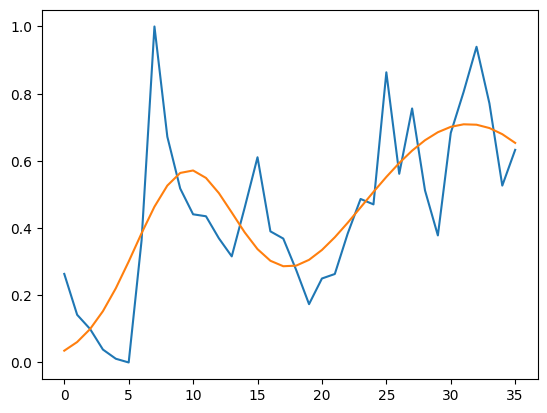

In [24]:
model = double_gaussian(x, fit[0])
plt.plot(curve)
plt.plot(model)
plt.show()

In [25]:
fit[0]

array([ 0.5351335 ,  9.42044815,  4.00222278,  0.7094157 , 31.36248146,
        8.97923484])